# Day4 花朵识别

## 1.GPU设置

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import os

from PIL import Image
import urllib.request
import tarfile
from pathlib import Path


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 2.下载数据

In [38]:
batch_size =32
img_height, img_width = 180, 180

url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_root = './'
tgz_path = os.path.join(data_root, "flower_phots.tgz")

if not os.path.exists(os.path.join(data_root, "flower_photos")):
    print("Downloading dataset...")
    urllib.request.urlretrieve(url, tgz_path)
    with tarfile.open(tgz_path, "r:gz") as tar:
        tar.extractall(path=data_root)
    print("Download and extraction complete.")

data_dir = os.path.join(data_root, "flower_photos")

transform = transforms.Compose([
                               transforms.RandomHorizontalFlip(),
                               transforms.RandomRotation(15),
                               transforms.Resize((img_height, img_width)),
                               transforms.ToTensor()])

dataset = datasets.ImageFolder(root = data_dir, transform = transform)
class_names = dataset.classes

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
generator = torch.Generator().manual_seed(40)
train_dataset, val_dataset= random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle=False)


## 3.可视化数据

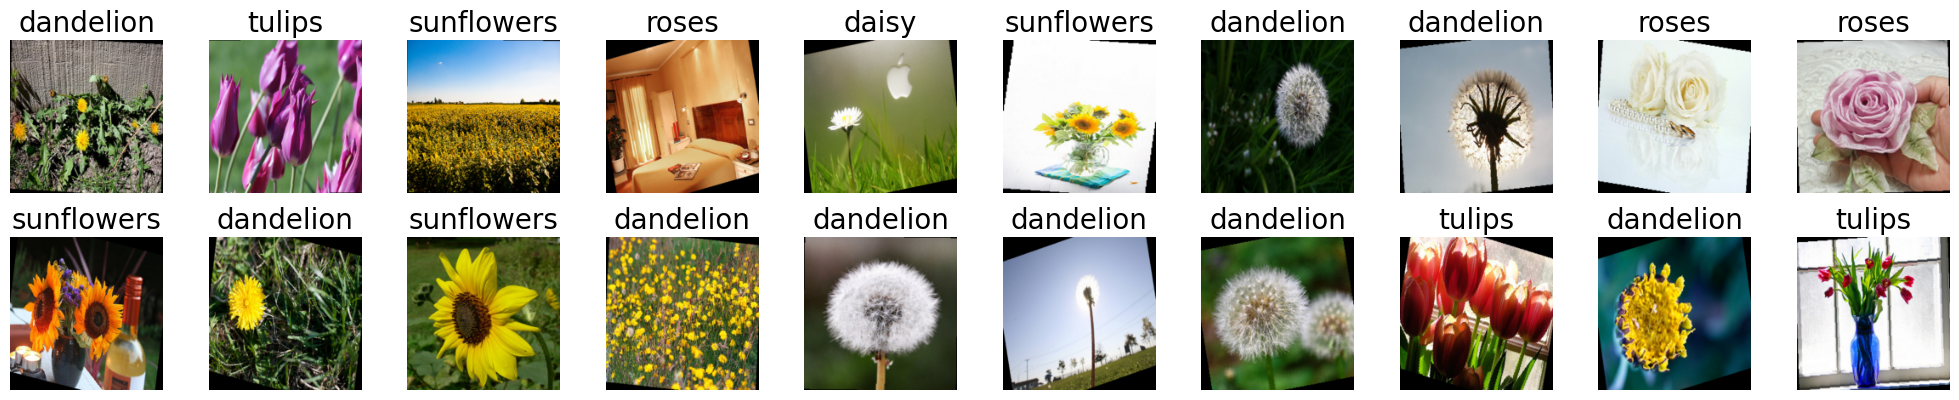

In [45]:
plt.figure(figsize = (20, 10))

for i in range(20):
    image, label = train_dataset[i]
    
    plt.subplot(5, 10, i+1)
    plt.imshow(image.permute(1, 2, 0))
    plt.title(class_names[label], fontsize=20)
    plt.axis('off')
    
plt.tight_layout()
plt.show()

## 4.构造CNN模型

In [39]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size =3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(16, 32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU()
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 41 * 41, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        x = self.net(x)
        x = self.classifier(x)
        return x
    
model = CNN(num_classes=len(class_names)).to(device)

## 4.损失和优化函数

In [40]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

## 5.训练以及验证模型

In [41]:
num_epochs = 10
train_acc_list = []
val_acc_list = []

In [42]:
for epoch in range(num_epochs):
    model.train()
    correct, total = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    train_acc = correct / total
    train_acc_list.append(train_acc)
    
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    val_acc = correct / total
    val_acc_list.append(val_acc)
    
    print(f"Epoch[{epoch +1} / {num_epochs}], Train Acc: {train_acc: .4f}, Val Acc: {val_acc:.4f}")

Epoch[1 / 10], Train Acc:  0.4373, Val Acc: 0.5627
Epoch[2 / 10], Train Acc:  0.5569, Val Acc: 0.6008
Epoch[3 / 10], Train Acc:  0.6196, Val Acc: 0.6594
Epoch[4 / 10], Train Acc:  0.6604, Val Acc: 0.6798
Epoch[5 / 10], Train Acc:  0.6907, Val Acc: 0.6812
Epoch[6 / 10], Train Acc:  0.7098, Val Acc: 0.6785
Epoch[7 / 10], Train Acc:  0.7268, Val Acc: 0.6975
Epoch[8 / 10], Train Acc:  0.7582, Val Acc: 0.6975
Epoch[9 / 10], Train Acc:  0.7759, Val Acc: 0.7044
Epoch[10 / 10], Train Acc:  0.7936, Val Acc: 0.7180


## 6.可视化准确率

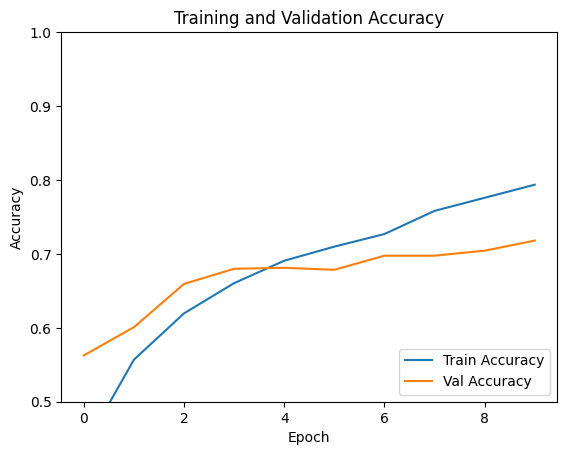

In [43]:
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(val_acc_list, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1.0])
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')
plt.show()

## 7.结论

1.模型在训练集上拟合能力很强。
2.在验证集上的性能随着训练轮数的提升并没有变大，甚至略有下降。
3.验证准确率明显低于训练准确率，说明存在过拟合。

## 8.分析出现过拟合的原因

1.模型容量过大： 参数量太多，比如模型中有64x41x41 = 105k维全连接输入
2.数据扩充缺失： 模型学习的很快，但泛化能力差。

## 9.解决方案

1.加入数据扩充（提升泛化能力）
2.减小模型复杂度
3.加入早停机制
4.使用Dropout防止过拟合

## 10.预测样例

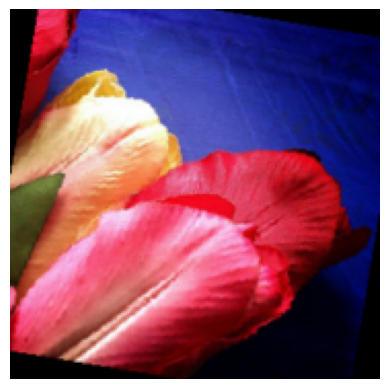

预测结果： tulips


In [47]:
test_image, test_label = val_dataset[1]

#显示图像
plt.imshow(test_image.permute(1, 2, 0))
plt.axis('off')
plt.show()

#预测结果
model.eval()
with torch.no_grad():
    output = model(test_image.unsqueeze(0))
    pred = torch.argmax(output, dim=1).item()
print('预测结果：', class_names[pred])  